In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/"

 clr_callback.py		 'Pet Adoption (CB) - PC.ipynb'
 Dataset			 'Pet Adoption (EDA).ipynb'
 learningratefinder.py		 'Pet Adoption (LGB) - BC.ipynb'
'NPZ Files'			 'Pet Adoption (LGB) - PC.ipynb'
'Pet Adoption (ANN) - BC.ipynb'  'Pet Adoption (XGB) - PC.ipynb'
'Pet Adoption (ANN) - PC.ipynb'   Predictions
'Pet Adoption (CB) - BC.ipynb'	  __pycache__


In [3]:
! pip install catboost

     |████████████████████████████████| 65.9MB 47kB/s 


In [4]:
! pip install optuna

     |████████████████████████████████| 235kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 13.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 133kB 23.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 112kB 16.0MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=e30cfa15f0d6f01498a3aa0a232958bcd385c8758d07a92bce10c8be519b2614
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-2.0.0-cp36-none-any.whl size=312964 sha256=5938aa758fb2c545b38d01216a1061b10b213abc157117ae817d57fef544b341
  Stored in directory: /root/.cache/pip/wheels/b5

## Import Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import optuna

## Set file paths for train and predict datasets

In [6]:
train_dataset = "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/train.csv"
predict_dataset = "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/test.csv"

## Data Preprocessing

### Read train and predict datasets

In [7]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (18834, 11)
predict_df: (8072, 9)


### Extract target variables into NumPy arrays

In [8]:
train_y_bc = train_df['breed_category']
train_df.drop(['breed_category','pet_category'], inplace=True, axis=1)
print("train_y_bc: {}".format(train_y_bc.shape))

train_y_bc: (18834,)


In [9]:
temp_df = pd.DataFrame(train_y_bc.values, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,9000
1,1.0,8357
2,2.0,1477


### Combine train and predict dataframes

In [10]:
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
combined_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4


### Feature Engineering

#### Issue Date and Listing Date

In [11]:
combined_df['iss_dt_year'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).year)
combined_df['iss_dt_quarter'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['iss_dt_month'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).month)
combined_df['iss_dt_week'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).week)
combined_df['iss_dt_day_year'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['iss_dt_day_month'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).day)
combined_df['iss_dt_day_week'] = combined_df['issue_date'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['iss_dt_day_weekend'] = np.where(combined_df['iss_dt_day_week'].isin([5,6]),1,0)

In [12]:
combined_df['lst_dt_year'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).year)
combined_df['lst_dt_quarter'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['lst_dt_month'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).month)
combined_df['lst_dt_week'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).week)
combined_df['lst_dt_day_year'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['lst_dt_day_month'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).day)
combined_df['lst_dt_day_week'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['lst_dt_day_weekend'] = np.where(combined_df['lst_dt_day_week'].isin([5,6]),1,0)
combined_df['lst_dt_hour'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).hour)
combined_df['lst_dt_minute'] = combined_df['listing_date'].map(lambda x: pd.to_datetime(x).minute)
combined_df['lst_dt_minutes_elapsed'] = combined_df['listing_date'].map(lambda x: (pd.to_datetime(x) - pd.to_datetime(pd.to_datetime(x).date())).seconds / 60.0)

In [13]:
combined_df['dt_diff'] = (pd.to_datetime(combined_df['listing_date']) - pd.to_datetime(combined_df['issue_date']))
combined_df['dt_diff_days'] = combined_df['dt_diff']/np.timedelta64(1,'D')
combined_df['dt_diff_weeks'] = combined_df['dt_diff']/np.timedelta64(1,'W')
combined_df['dt_diff_mnths'] = combined_df['dt_diff']/np.timedelta64(1,'M')
combined_df['dt_diff_yrs'] = combined_df['dt_diff']/np.timedelta64(1,'Y')
combined_df['dt_diff_sec'] = combined_df['dt_diff']/np.timedelta64(1,'s')
combined_df['dt_diff_min'] = combined_df['dt_diff']/np.timedelta64(1,'m')
combined_df['dt_diff_hrs'] = combined_df['dt_diff']/np.timedelta64(1,'h')

In [14]:
combined_df['curr_iss_dt_diff'] = (pd.datetime.now() - pd.to_datetime(combined_df['issue_date']))
combined_df['curr_iss_dt_diff_mnths'] = combined_df['curr_iss_dt_diff']/np.timedelta64(1,'M')
combined_df['curr_iss_dt_diff_yrs'] = combined_df['curr_iss_dt_diff']/np.timedelta64(1,'Y')

combined_df['curr_lst_dt_diff'] = (pd.datetime.now() - pd.to_datetime(combined_df['listing_date']))
combined_df['curr_lst_dt_diff_mnths'] = combined_df['curr_lst_dt_diff']/np.timedelta64(1,'M')
combined_df['curr_lst_dt_diff_yrs'] = combined_df['curr_lst_dt_diff']/np.timedelta64(1,'Y')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [15]:
combined_df.drop(['issue_date', 'listing_date', 'dt_diff', 'curr_iss_dt_diff', 'curr_lst_dt_diff'], axis=1, inplace=True)
combined_df.head()

,pet_id,condition,color_type,length(m),height(cm),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs
0,ANSL_69903,2.0,Brown Tabby,0.80,7.78,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.461241,4.121770,47.040361,3.920030
1,ANSL_66892,1.0,White,0.72,14.19,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.067640,6.755637,19.867501,1.655625
2,ANSL_69750,NaN,Brown,0.15,40.90,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.849771,5.904148,46.131399,3.844283
3,ANSL_71623,1.0,White,0.62,17.82,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.744492,3.645374,18.913728,1.576144
4,ANSL_57969,2.0,Black,0.50,11.06,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.840818,2.903401,33.119176,2.759931


#### Condition

In [16]:
combined_df['condition'] = combined_df['condition'].fillna(value=3)
combined_df['condition'] = combined_df['condition'].apply(lambda x: int(x))
combined_df['condition_odd_even'] = combined_df['condition'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')
combined_df['condition_odd_even_enc'] = combined_df['condition_odd_even'].factorize()[0]
combined_df.drop(['condition_odd_even'], axis=1, inplace=True)

In [17]:
combined_df['condition*X1'] = np.cbrt(combined_df['condition'] * combined_df['X1'])
combined_df['condition*X2'] = combined_df['condition'] * combined_df['X2']

In [18]:
combined_df['condition%X1'] = combined_df.apply(lambda row: 0 if row['condition']==0 else row['X1']%row['condition'], axis=1)
combined_df['condition%X2'] = combined_df.apply(lambda row: 0 if row['condition']==0 else row['X2']%row['condition'], axis=1)

#### Pet Id

In [19]:
combined_df['pet_id_num'] = combined_df['pet_id'].apply(lambda x: x.split('_')[1]).astype(int)
combined_df.head()

,pet_id,condition,color_type,length(m),height(cm),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_odd_even_enc,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_num
0,ANSL_69903,2,Brown Tabby,0.80,7.78,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.461241,4.121770,47.040361,3.920030,0,2.962496,18,1,1,69903
1,ANSL_66892,1,White,0.72,14.19,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.067640,6.755637,19.867501,1.655625,1,2.351335,9,0,0,66892
2,ANSL_69750,3,Brown,0.15,40.90,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.849771,5.904148,46.131399,3.844283,1,3.556893,12,0,1,69750
3,ANSL_71623,1,White,0.62,17.82,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.744492,3.645374,18.913728,1.576144,1,0.000000,1,0,0,71623
4,ANSL_57969,2,Black,0.50,11.06,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.840818,2.903401,33.119176,2.759931,0,3.301927,8,0,0,57969


In [20]:
combined_df['pet_id_odd_even'] = combined_df['pet_id_num'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')
combined_df['pet_id_odd_even_enc'] = combined_df['pet_id_odd_even'].factorize()[0]
combined_df['petid%X1'] = combined_df.apply(lambda row: 0 if row['X1']==0 else row['pet_id_num']%row['X1'], axis=1)
combined_df['petid%X2'] = combined_df.apply(lambda row: 0 if row['X2']==0 else row['pet_id_num']%row['X2'], axis=1)
combined_df['petid%condition'] = combined_df.apply(lambda row: 0 if row['condition']==0 else row['pet_id_num']%row['condition'], axis=1)

In [21]:
combined_df['pet_id_0'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[0]))
combined_df['pet_id_1'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[1]))
combined_df['pet_id_2'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[2]))
combined_df['pet_id_3'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[3]))
combined_df['pet_id_4'] = combined_df['pet_id_num'].apply(lambda x: int(str(x)[4]))

In [22]:
combined_df.drop(['pet_id', 'pet_id_num', 'pet_id_odd_even'], axis=1, inplace=True)
combined_df.head()

,condition,color_type,length(m),height(cm),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_odd_even_enc,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_odd_even_enc,petid%X1,petid%X2,petid%condition,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4
0,2,Brown Tabby,0.80,7.78,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.461241,4.121770,47.040361,3.920030,0,2.962496,18,1,1,0,2,0,1,6,9,9,0,3
1,1,White,0.72,14.19,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.067640,6.755637,19.867501,1.655625,1,2.351335,9,0,0,1,7,4,0,6,6,8,9,2
2,3,Brown,0.15,40.90,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.849771,5.904148,46.131399,3.844283,1,3.556893,12,0,1,1,0,2,0,6,9,7,5,0
3,1,White,0.62,17.82,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.744492,3.645374,18.913728,1.576144,1,0.000000,1,0,0,0,0,0,0,7,1,6,2,3
4,2,Black,0.50,11.06,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.840818,2.903401,33.119176,2.759931,0,3.301927,8,0,0,0,9,1,1,5,7,9,6,9


#### Length and Height

In [23]:
combined_df['height(m)'] = combined_df['height(cm)']/100

In [24]:
combined_df['length_scale_10'] = np.array(np.round((combined_df['length(m)'] * 10)), dtype='int')
combined_df['length_scale_100'] = np.array(np.round((combined_df['length(m)'] * 100)), dtype='int')

combined_df['height_scale_10'] = np.array(np.round((combined_df['height(m)'] * 10)), dtype='int')
combined_df['height_scale_100'] = np.array(np.round((combined_df['height(m)'] * 100)), dtype='int')
combined_df['height_scale_1000'] = np.array(np.round((combined_df['height(m)'] * 1000)), dtype='int')

In [25]:
combined_df['diag(cm)'] = np.sqrt(combined_df['length(m)']**2 + combined_df['height(m)']**2)*100
combined_df['cbrt(m)'] = np.cbrt(combined_df['length(m)']**2 + combined_df['height(m)']**2)
combined_df['area(m)'] = np.sqrt(combined_df['length(m)'] * combined_df['height(m)'])

In [26]:
combined_df['l_vs_h'] = combined_df.apply(lambda row: 'l=h' if np.round(row['length(m)'],1)==np.round(row['height(m)'],1) else 
                                          'l>h' if np.round(row['length(m)'],1)>np.round(row['height(m)'],1) else 
                                          'l<h' if np.round(row['length(m)'],1)<np.round(row['height(m)'],1) else 'NA', axis=1)
combined_df['l_vs_h_enc'] = combined_df['l_vs_h'].factorize()[0]

In [27]:
combined_df['pet_size'] = combined_df['diag(cm)'].apply(lambda x: 'SMALL' if x<=40 else 'MEDIUM' if x>40 and x<=80 else 'BIG')
combined_df['pet_size_enc'] = combined_df['pet_size'].factorize()[0]

In [28]:
combined_df.drop(['height(cm)', 'l_vs_h', 'pet_size'], axis=1, inplace=True)
combined_df.head()

,condition,color_type,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_odd_even_enc,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_odd_even_enc,petid%X1,petid%X2,petid%condition,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4,height(m),length_scale_10,length_scale_100,height_scale_10,height_scale_100,height_scale_1000,diag(cm),cbrt(m),area(m),l_vs_h_enc,pet_size_enc
0,2,Brown Tabby,0.80,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.461241,4.121770,47.040361,3.920030,0,2.962496,18,1,1,0,2,0,1,6,9,9,0,3,0.0778,8,80,1,8,78,80.377412,0.864482,0.249479,0,0
1,1,White,0.72,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.067640,6.755637,19.867501,1.655625,1,2.351335,9,0,0,1,7,4,0,6,6,8,9,2,0.1419,7,72,1,14,142,73.384986,0.813589,0.319637,0,1
2,3,Brown,0.15,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.849771,5.904148,46.131399,3.844283,1,3.556893,12,0,1,1,0,2,0,6,9,7,5,0,0.4090,2,15,4,41,409,43.563861,0.574669,0.247689,1,1
3,1,White,0.62,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.744492,3.645374,18.913728,1.576144,1,0.000000,1,0,0,0,0,0,0,7,1,6,2,3,0.1782,6,62,2,18,178,64.510095,0.746595,0.332391,0,1
4,2,Black,0.50,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.840818,2.903401,33.119176,2.759931,0,3.301927,8,0,0,0,9,1,1,5,7,9,6,9,0.1106,5,50,1,11,111,51.208628,0.640072,0.235160,0,1


#### Color Type

In [29]:
combined_df['subcolor_type1'] = combined_df['color_type'].apply(lambda x: x.split()[0])
combined_df['subcolor_type1_enc'] = combined_df['subcolor_type1'].factorize()[0]

combined_df['subcolor_type2'] = combined_df['color_type'].apply(lambda x: 'NONE' if len(x.split())==1 else x.split()[1])
combined_df['subcolor_type2_enc'] = combined_df['subcolor_type2'].factorize()[0]

In [30]:
combined_df["color_type_num_words"] = combined_df["color_type"].apply(lambda x: len(str(x).split()))
combined_df["color_type_num_chars"] = combined_df["color_type"].apply(lambda x: len(str(x)))

In [31]:
tfidf = TfidfVectorizer(analyzer='char')
features = tfidf.fit_transform(combined_df.color_type).toarray()
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names())
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

(26906, 24)


In [32]:
countvec = CountVectorizer(analyzer='char')
features = countvec.fit_transform(combined_df.color_type).toarray()
features_df = pd.DataFrame(features, columns=countvec.get_feature_names())
print(features_df.shape)
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

(26906, 24)


In [33]:
combined_df.drop(['color_type', 'subcolor_type1', 'subcolor_type2'], axis=1, inplace=True)
combined_df.head()

,condition,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_odd_even_enc,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_odd_even_enc,...,h_x,i_x,k_x,l_x,m_x,n_x,o_x,p_x,r_x,s_x,t_x,u_x,v_x,w_x,x_x,y_x,_y,a_y,b_y,c_y,d_y,e_y,f_y,g_y,h_y,i_y,k_y,l_y,m_y,n_y,o_y,p_y,r_y,s_y,t_y,u_y,v_y,w_y,x_y,y_y
0,2,0.80,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.461241,4.121770,47.040361,3.920030,0,2.962496,18,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.276002,0.269639,0.0,0.262714,0.0,0.241936,0.0,0.0,0.276241,0.0,0.356584,1,1,3,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1
1,1,0.72,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.067640,6.755637,19.867501,1.655625,1,2.351335,9,0,0,1,...,0.587465,0.469963,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.354338,0.0,0.0,0.404581,0.0,0.000000,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,3,0.15,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.849771,5.904148,46.131399,3.844283,1,3.556893,12,0,1,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.477268,0.466266,0.0,0.454291,0.0,0.000000,0.0,0.0,0.477682,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
3,1,0.62,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.744492,3.645374,18.913728,1.576144,1,0.000000,1,0,0,0,...,0.587465,0.469963,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.354338,0.0,0.0,0.404581,0.0,0.000000,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,2,0.50,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.840818,2.903401,33.119176,2.759931,0,3.301927,8,0,0,0,...,0.000000,0.000000,0.560885,0.425915,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


#### X1 and X2

In [34]:
combined_df['X1_odd_even'] = combined_df['X1'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')
combined_df['X2_odd_even'] = combined_df['X2'].apply(lambda x: 'EVEN' if x%2==0 else 'ODD')

combined_df['X1_odd_even_enc'] = combined_df['X1_odd_even'].factorize()[0]
combined_df['X2_odd_even_enc'] = combined_df['X2_odd_even'].factorize()[0]

In [35]:
combined_df['Xavg'] = (combined_df['X1']+combined_df['X2'])/2
combined_df['Xdiff'] = np.abs(combined_df['X1']-combined_df['X2'])
combined_df['Xmul'] = combined_df['X1']*combined_df['X2']
combined_df['Xdiv'] = combined_df.apply(lambda row: 0 if row['X1']==0 or row['X2']==0 else row['X2']/row['X1'], axis=1)
combined_df['Xdiv'] = np.cbrt(combined_df['Xdiv'])
combined_df['Xmod'] = combined_df.apply(lambda row: 0 if row['X1']==0 or row['X2']==0 else row['X1']%row['X2'], axis=1)
combined_df['Xdiag'] = np.sqrt(combined_df['X1']**2 + combined_df['X2']**2)
combined_df['Xcbrt'] = np.cbrt(combined_df['X1']**2 + combined_df['X2']**2)

In [36]:
combined_df['X1_cat'] = combined_df['X1'].apply(lambda x: '<=6' if x<=6 else '6to13' if x>6 and x<=13 else '>13')
combined_df['X2_cat'] = combined_df['X2'].apply(lambda x: '<=3' if x<=3 else '4to7' if x>3 and x<=7 else '>7')

combined_df['X1_cat_enc'] = combined_df['X1_cat'].factorize()[0]
combined_df['X2_cat_enc'] = combined_df['X2_cat'].factorize()[0]

In [37]:
combined_df['X1_vs_X2'] = combined_df.apply(lambda row: 'X1=X2' if row['X1']==row['X2'] else 
                                            'X1>X2' if row['X1']>row['X2'] else 
                                            'X1<X2' if row['X1']<row['X2'] else 'NA', axis=1)

combined_df['X1_vs_X2_enc'] = combined_df['X1_vs_X2'].factorize()[0]

In [38]:
#combined_df['length/X1'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['X1']==0 else row['length(m)']/row['X1'], axis=1)
combined_df['length/X2'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['X2']==0 else row['length(m)']/row['X2'], axis=1)
combined_df['length/Xavg'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['Xavg']==0 else np.log1p(row['length(m)']/row['Xavg']), axis=1)
combined_df['length/Xdiag'] = combined_df.apply(lambda row: 0 if row['length(m)']==0 or row['Xdiag']==0 else np.log1p(row['length(m)']/row['Xdiag']), axis=1)

In [39]:
#combined_df['height/X1'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['X1']==0 else row['height(m)']/row['X1'], axis=1)
combined_df['height/X2'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['X2']==0 else row['height(m)']/row['X2'], axis=1)
combined_df['height/Xavg'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['Xavg']==0 else np.log1p(row['height(m)']/row['Xavg']), axis=1)
combined_df['height/Xdiag'] = combined_df.apply(lambda row: 0 if row['height(m)']==0 or row['Xdiag']==0 else np.log1p(row['length(m)']/row['Xdiag']), axis=1)

In [40]:
#combined_df['diag/X1'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['X1']==0 else row['diag(cm)']/row['X1'], axis=1)
combined_df['diag/X2'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['X2']==0 else row['diag(cm)']/row['X2'], axis=1)
combined_df['diag/Xavg'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['Xavg']==0 else np.log1p(row['diag(cm)']/row['Xavg']), axis=1)
combined_df['diag/Xdiag'] = combined_df.apply(lambda row: 0 if row['diag(cm)']==0 or row['Xdiag']==0 else np.log1p(row['diag(cm)']/row['Xdiag']), axis=1)

In [41]:
#combined_df['area/X1'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['X1']==0 else row['area(m)']/row['X1'], axis=1)
combined_df['area/X2'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['X2']==0 else row['area(m)']/row['X2'], axis=1)
combined_df['area/Xavg'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['Xavg']==0 else np.log1p(row['area(m)']/row['Xavg']), axis=1)
combined_df['area/Xdiag'] = combined_df.apply(lambda row: 0 if row['area(m)']==0 or row['Xdiag']==0 else np.log1p(row['area(m)']/row['Xdiag']), axis=1)

In [42]:
combined_df.drop(['X1_odd_even', 'X2_odd_even', 'X1_cat', 'X2_cat', 'X1_vs_X2'], axis=1, inplace=True)
combined_df.head()

,condition,length(m),X1,X2,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_week,iss_dt_day_year,iss_dt_day_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_week,lst_dt_day_year,lst_dt_day_month,lst_dt_day_week,lst_dt_day_weekend,lst_dt_hour,lst_dt_minute,lst_dt_minutes_elapsed,dt_diff_days,dt_diff_weeks,dt_diff_mnths,dt_diff_yrs,dt_diff_sec,dt_diff_min,dt_diff_hrs,curr_iss_dt_diff_mnths,curr_iss_dt_diff_yrs,curr_lst_dt_diff_mnths,curr_lst_dt_diff_yrs,condition_odd_even_enc,condition*X1,condition*X2,condition%X1,condition%X2,pet_id_odd_even_enc,...,h_y,i_y,k_y,l_y,m_y,n_y,o_y,p_y,r_y,s_y,t_y,u_y,v_y,w_y,x_y,y_y,X1_odd_even_enc,X2_odd_even_enc,Xavg,Xdiff,Xmul,Xdiv,Xmod,Xdiag,Xcbrt,X1_cat_enc,X2_cat_enc,X1_vs_X2_enc,length/X2,length/Xavg,length/Xdiag,height/X2,height/Xavg,height/Xdiag,diag/X2,diag/Xavg,diag/Xdiag,area/X2,area/Xavg,area/Xdiag
0,2,0.80,13,9,2016,3,7,27,192,10,6,1,2016,3,9,38,265,21,2,0,16,25,985.0,73.684028,10.526290,2.420880,0.201740,6366300.0,106105.0,1768.416667,49.461241,4.121770,47.040361,3.920030,0,2.962496,18,1,1,0,...,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,11.0,4,117,0.884640,4,15.811388,6.299605,0,0,0,0.088889,0.070204,0.049358,0.008644,0.007048,0.049358,8.930824,2.117103,1.805582,0.027720,0.022427,0.015655
1,1,0.72,13,9,2013,4,11,47,325,21,3,0,2018,4,12,52,361,27,3,0,17,47,1067.0,1862.740972,266.105853,61.200139,5.100012,160940820.0,2682347.0,44705.783333,81.067640,6.755637,19.867501,1.655625,1,2.351335,9,0,0,1,...,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,11.0,4,117,0.884640,4,15.811388,6.299605,0,0,0,0.080000,0.063402,0.044530,0.015767,0.012818,0.044530,8.153887,2.037494,1.730110,0.035515,0.028644,0.020014
2,3,0.15,15,4,2014,3,9,39,271,28,6,1,2016,4,10,42,293,19,2,0,8,24,504.0,752.350000,107.478571,24.718372,2.059864,65003040.0,1083384.0,18056.400000,70.849771,5.904148,46.131399,3.844283,1,3.556893,12,0,1,1,...,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,9.5,11,60,0.643660,3,15.524175,6.223084,1,1,0,0.037500,0.015666,0.009616,0.102250,0.042152,0.009616,10.890965,1.720204,1.336630,0.061922,0.025738,0.015829
3,1,0.62,0,1,2016,4,12,52,366,31,5,1,2019,1,1,4,25,25,4,0,18,30,1110.0,755.770833,107.967262,24.830763,2.069230,65298600.0,1088310.0,18138.500000,43.744492,3.645374,18.913728,1.576144,1,0.000000,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0.5,1,0,0.000000,0,1.000000,1.000000,2,2,1,0.620000,0.806476,0.482426,0.178200,0.304834,0.482426,64.510095,4.867690,4.182204,0.332391,0.509695,0.286975
4,2,0.50,18,4,2017,3,9,39,271,28,3,0,2017,4,11,46,323,19,6,1,9,38,578.0,52.401389,7.485913,1.721642,0.143470,4527480.0,75458.0,1257.633333,34.840818,2.903401,33.119176,2.759931,0,3.301927,8,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,11.0,14,72,0.605707,2,18.439089,6.979532,1,1,0,0.125000,0.044452,0.026755,0.027650,0.010004,0.026755,12.802157,1.732598,1.328977,0.058790,0.021153,0.012673


### Define categorical columns

In [43]:
categorical_columns = ['iss_dt_year','iss_dt_quarter','iss_dt_month','iss_dt_day_week','iss_dt_day_weekend','lst_dt_year','lst_dt_quarter','lst_dt_month','lst_dt_day_week','lst_dt_day_weekend',
                       'condition','condition_odd_even_enc', 'condition%X1','condition%X2','pet_id_odd_even_enc','petid%X1','petid%X2','petid%condition','pet_id_0','pet_id_1','pet_id_2','pet_id_3',
                       'pet_id_4','l_vs_h_enc','pet_size_enc','subcolor_type1_enc','subcolor_type2_enc','X1_odd_even_enc','X2_odd_even_enc','X1_cat_enc','X2_cat_enc','X1_vs_X2_enc','X1','X2']
categorical_columns_indices = [combined_df.columns.get_loc(col) for col in categorical_columns]
print(categorical_columns_indices)

[4, 5, 6, 10, 11, 12, 13, 14, 18, 19, 0, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 57, 58, 59, 60, 111, 112, 120, 121, 122, 2, 3]


In [44]:
combined_df[categorical_columns].head()

,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_day_week,lst_dt_day_weekend,condition,condition_odd_even_enc,condition%X1,condition%X2,pet_id_odd_even_enc,petid%X1,petid%X2,petid%condition,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4,l_vs_h_enc,pet_size_enc,subcolor_type1_enc,subcolor_type2_enc,X1_odd_even_enc,X2_odd_even_enc,X1_cat_enc,X2_cat_enc,X1_vs_X2_enc,X1,X2
0,2016,3,7,6,1,2016,3,9,2,0,2,0,1,1,0,2,0,1,6,9,9,0,3,0,0,0,0,0,0,0,0,0,13,9
1,2013,4,11,3,0,2018,4,12,3,0,1,1,0,0,1,7,4,0,6,6,8,9,2,0,1,1,1,0,0,0,0,0,13,9
2,2014,3,9,6,1,2016,4,10,2,0,3,1,0,1,1,0,2,0,6,9,7,5,0,1,1,0,1,0,1,1,1,0,15,4
3,2016,4,12,5,1,2019,1,1,4,0,1,1,0,0,0,0,0,0,7,1,6,2,3,0,1,1,1,1,0,2,2,1,0,1
4,2017,3,9,3,0,2017,4,11,6,1,2,0,0,0,0,9,1,1,5,7,9,6,9,0,1,2,1,1,1,1,1,0,18,4


### Create train and predict Numpy arrays

In [45]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:18834]
predict_x = combined_df[18834:]

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (18834, 135)
predict_x: (8072, 135)


In [46]:
train_x_bc = train_x.copy()
Xpredict = predict_x.copy()

### Split training data into train/ validation/ test datasets

In [47]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in sss.split(train_x_bc.values, train_y_bc.values):
    Xtrain_bc, Xvalidation_bc = train_x_bc.iloc[train_index], train_x_bc.iloc[test_index]
    Ytrain_bc, Yvalidation_bc = train_y_bc.iloc[train_index], train_y_bc.iloc[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=20)
for train_index, test_index in sss.split(Xvalidation_bc.values, Yvalidation_bc.values):
    Xvalidation_bc, Xtest_bc = Xvalidation_bc.iloc[train_index], Xvalidation_bc.iloc[test_index]
    Yvalidation_bc, Ytest_bc = Yvalidation_bc.iloc[train_index], Yvalidation_bc.iloc[test_index]

print("------------------------- Training Dataset -------------------------")
print("Xtrain_bc shape: {}".format(Xtrain_bc.shape))
print("Ytrain_bc shape: {}".format(Ytrain_bc.shape))

print("\n------------------------- Validation Dataset -------------------------")
print("Xvalidation_bc shape: {}".format(Xvalidation_bc.shape))
print("Yvalidation_bc shape: {}".format(Yvalidation_bc.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_bc shape: {}".format(Xtest_bc.shape))
print("Ytest_bc shape: {}".format(Ytest_bc.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_bc shape: (15067, 135)
Ytrain_bc shape: (15067,)

------------------------- Validation Dataset -------------------------
Xvalidation_bc shape: (2260, 135)
Yvalidation_bc shape: (2260,)

------------------------- Test Dataset -------------------------
Xtest_bc shape: (1507, 135)
Ytest_bc shape: (1507,)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (8072, 135)


In [48]:
Xtrain_bc = pd.DataFrame(Xtrain_bc, columns=train_x.columns)
Xtrain_bc[categorical_columns] = Xtrain_bc[categorical_columns].astype(int)
Xtrain_bc[categorical_columns].head()

,iss_dt_year,iss_dt_quarter,iss_dt_month,iss_dt_day_week,iss_dt_day_weekend,lst_dt_year,lst_dt_quarter,lst_dt_month,lst_dt_day_week,lst_dt_day_weekend,condition,condition_odd_even_enc,condition%X1,condition%X2,pet_id_odd_even_enc,petid%X1,petid%X2,petid%condition,pet_id_0,pet_id_1,pet_id_2,pet_id_3,pet_id_4,l_vs_h_enc,pet_size_enc,subcolor_type1_enc,subcolor_type2_enc,X1_odd_even_enc,X2_odd_even_enc,X1_cat_enc,X2_cat_enc,X1_vs_X2_enc,X1,X2
146,2011,4,11,4,0,2016,4,12,6,1,0,0,0,0,0,0,6,0,6,9,1,5,9,0,1,1,1,1,0,2,1,1,0,7
5665,2010,3,8,6,1,2018,1,2,3,0,1,1,0,0,1,1,0,0,5,1,1,6,4,0,2,2,1,0,0,0,2,0,7,1
5864,2016,4,12,0,0,2017,2,4,0,0,0,0,0,0,0,12,7,0,5,5,9,5,1,0,0,2,1,0,0,0,0,0,13,9
15080,2015,1,2,1,0,2017,1,3,4,0,3,1,0,2,1,4,0,1,5,0,8,3,6,0,0,2,1,1,1,2,2,0,6,2
532,2018,2,4,5,1,2018,3,7,0,0,1,1,0,0,0,5,0,0,5,4,8,9,9,0,0,0,0,0,0,0,2,0,7,1


In [49]:
Ytrain_bc = pd.DataFrame(Ytrain_bc.values, columns=['Class'])

tmp = Yvalidation_bc.values
Yvalidation_bc = pd.DataFrame(tmp, columns=['Class'])

tmp = Ytest_bc.values
Ytest_bc = pd.DataFrame(tmp, columns=['Class'])

In [50]:
temp_df = pd.DataFrame(Ytrain_bc.values, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,7200
1,1.0,6685
2,2.0,1182


In [51]:
temp_df = pd.DataFrame(Yvalidation_bc.values, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,1080
1,1.0,1003
2,2.0,177


In [52]:
temp_df = pd.DataFrame(Ytest_bc.values, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

,Class,count
0,0.0,720
1,1.0,669
2,2.0,118


## Breed Category Prediction

In [53]:
def plot_confusion_matrix(cm, classes):
  
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Hyperparameter search using Optuna

In [ ]:
def objective(trial):
    
    model = CatBoostClassifier(
        objective='MultiClass',
        eval_metric='MultiClass',
        num_boost_round=5000,
        class_weights=[0.164, 0.177, 1],
        learning_rate=trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-4, 1.0),
        bootstrap_type='Poisson',
        subsample=trial.suggest_uniform("subsample", 0.5, 1.0),
        max_depth=trial.suggest_int("max_depth", 6, 15), 
        grow_policy='Lossguide',
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 15), 
        max_leaves=trial.suggest_int("max_leaves", 50, 5000),
        task_type='GPU',
        verbose=0
    )

    model.fit(Xtrain_bc, Ytrain_bc, eval_set=[(Xvalidation_bc, Yvalidation_bc)], 
              cat_features=categorical_columns_indices,
              early_stopping_rounds=200, verbose=False)
    y_pred = model.predict(Xtest_bc)
    y_pred = y_pred.astype(int)
    f1 = f1_score(Ytest_bc, y_pred, average='weighted')

    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2020-08-23 09:41:32,788] Trial 0 finished with value: 0.9031469174038323 and parameters: {'learning_rate': 0.06708049349993156, 'reg_lambda': 0.0030982946938633406, 'max_depth': 6, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9031469174038323.
[I 2020-08-23 09:41:54,711] Trial 1 finished with value: 0.8984859055102417 and parameters: {'learning_rate': 0.023691886033693984, 'reg_lambda': 0.0007571783940249974, 'max_depth': 7, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9031469174038323.
[I 2020-08-23 09:42:05,927] Trial 2 finished with value: 0.9024825293067719 and parameters: {'learning_rate': 0.0654767465659395, 'reg_lambda': 0.2837754344552973, 'max_depth': 6, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9031469174038323.
[I 2020-08-23 09:43:11,462] Trial 3 finished with value: 0.9057205810852687 and parameters: {'learning_rate': 0.06819368441315642, 'reg_lambda': 0.00018785124702936593, 'max_depth': 12, 'min_data_in_leaf': 1}. Best is trial 3 with valu

KeyboardInterrupt: ignored

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 11
Best trial:
Value: 0.9070484602249127
Params: 
 learning_rate: 0.030073284502058054
 reg_lambda: 0.00033442837161898185
 max_depth: 14
 min_data_in_leaf: 12


### Build the model for breed-category prediction

In [55]:
Xtrain_tmp = pd.concat([Xtrain_bc, Xvalidation_bc], axis=0)
Ytrain_tmp = pd.concat([Ytrain_bc, Yvalidation_bc], axis=0)

In [54]:
# Define K-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
y_pred = 0

In [92]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_tmp.values, Ytrain_tmp.values):
    counter += 1

    train_x, train_y = Xtrain_tmp.iloc[train], Ytrain_tmp.iloc[train]
    val_x, val_y = Xtrain_tmp.iloc[val], Ytrain_tmp.iloc[val]

    model = CatBoostClassifier(
        objective='MultiClass',
        eval_metric='TotalF1',
        num_boost_round=5000,
        class_weights=[0.165, 0.185, 1],
        learning_rate=0.025,
        reg_lambda=0.009,
        bootstrap_type='Poisson',
        subsample=0.6,
        max_depth=8, 
        grow_policy='Lossguide',
        min_data_in_leaf=2, 
        max_leaves=157,
        task_type='GPU',
        verbose=0
    )

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
              cat_features=categorical_columns_indices,
              early_stopping_rounds=200, verbose=100)
    pred = model.predict(Xtest_bc)

    y_pred = y_pred + pred

y_pred = y_pred/float(counter)

0:	learn: 0.9330900	test: 0.9302476	best: 0.9302476 (0)	total: 46.2ms	remaining: 3m 50s
100:	learn: 0.9766467	test: 0.9347906	best: 0.9398750 (47)	total: 5.52s	remaining: 4m 27s
200:	learn: 0.9909293	test: 0.9385729	best: 0.9398750 (47)	total: 13.9s	remaining: 5m 33s
bestTest = 0.9398750348
bestIteration = 47
Shrink model to first 48 iterations.
0:	learn: 0.9344316	test: 0.9212380	best: 0.9212380 (0)	total: 46.4ms	remaining: 3m 52s
100:	learn: 0.9803388	test: 0.9269195	best: 0.9272180 (85)	total: 5.41s	remaining: 4m 22s
200:	learn: 0.9922947	test: 0.9295234	best: 0.9305597 (165)	total: 13.9s	remaining: 5m 30s
300:	learn: 0.9976671	test: 0.9304155	best: 0.9316323 (205)	total: 23.1s	remaining: 6m 1s
400:	learn: 0.9995283	test: 0.9272158	best: 0.9316323 (205)	total: 32.6s	remaining: 6m 13s
bestTest = 0.9316322856
bestIteration = 205
Shrink model to first 206 iterations.
0:	learn: 0.9375455	test: 0.9229746	best: 0.9229746 (0)	total: 45.3ms	remaining: 3m 46s
100:	learn: 0.9797735	test: 0.92

### Validate the model

In [93]:
# Print log_loss, accuracy and F1-score
y_pred = y_pred.astype(int)
f1 = f1_score(Ytest_bc, y_pred, average='weighted')
print('Overall F1-Score:', f1)

Overall F1-Score: 0.9046607045222241


In [94]:
print(classification_report(Ytest_bc, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91       720
         1.0       0.94      0.84      0.89       669
         2.0       1.00      1.00      1.00       118

    accuracy                           0.91      1507
   macro avg       0.94      0.93      0.93      1507
weighted avg       0.91      0.91      0.90      1507



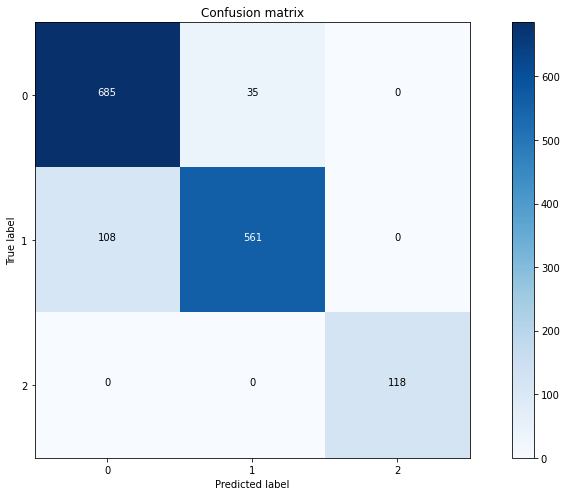

In [95]:
cnf_matrix = confusion_matrix(Ytest_bc, y_pred, labels=[0, 1, 2])
np.set_printoptions(precision=2)
plt.figure(figsize=(12,7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2])

## Train model on entire data

In [ ]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
y_pred = 0

In [ ]:
Xtrain_tmp = pd.concat([Xtrain_bc, Xvalidation_bc, Xtest_bc], axis=0)
Ytrain_tmp = pd.concat([Ytrain_bc, Yvalidation_bc, Ytest_bc], axis=0)

In [ ]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_tmp.values, Ytrain_tmp.values):
    counter += 1

    train_x, train_y = Xtrain_tmp.iloc[train], Ytrain_tmp.iloc[train]
    val_x, val_y = Xtrain_tmp.iloc[val], Ytrain_tmp.iloc[val]

    model = CatBoostClassifier(
        objective='MultiClass',
        eval_metric='MultiClass',
        num_boost_round=5000,
        class_weights=[0.164, 0.177, 1],
        learning_rate=0.0406,
        reg_lambda=0.00029,
        bootstrap_type='Poisson',
        subsample=0.5643,
        max_depth=8, 
        grow_policy='Lossguide',
        min_data_in_leaf=2, 
        max_leaves=117,
        task_type='GPU',
        verbose=0
    )

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
              cat_features=categorical_columns_indices,
              early_stopping_rounds=200, verbose=100)
    pred = model.predict(Xpredict)

    y_pred = y_pred + pred

y_pred = y_pred/float(counter)

0:	learn: 1.0280024	test: 1.0281198	best: 1.0281198 (0)	total: 38ms	remaining: 3m 10s
100:	learn: 0.1050268	test: 0.1168676	best: 0.1168676 (100)	total: 5.32s	remaining: 4m 17s
200:	learn: 0.0791203	test: 0.1066342	best: 0.1066071 (199)	total: 12.7s	remaining: 5m 3s
300:	learn: 0.0657450	test: 0.1062772	best: 0.1060258 (274)	total: 20.3s	remaining: 5m 16s
400:	learn: 0.0531349	test: 0.1072033	best: 0.1060258 (274)	total: 29.1s	remaining: 5m 33s
bestTest = 0.1060257839
bestIteration = 274
Shrink model to first 275 iterations.
0:	learn: 1.0281437	test: 1.0279263	best: 1.0279263 (0)	total: 31.4ms	remaining: 2m 37s
100:	learn: 0.1051343	test: 0.1153291	best: 0.1153291 (100)	total: 4.79s	remaining: 3m 52s
200:	learn: 0.0795654	test: 0.1052250	best: 0.1052216 (197)	total: 11.9s	remaining: 4m 44s
300:	learn: 0.0656247	test: 0.1049410	best: 0.1049410 (300)	total: 19.3s	remaining: 5m 1s
400:	learn: 0.0545490	test: 0.1057847	best: 0.1049410 (300)	total: 27s	remaining: 5m 9s
500:	learn: 0.0450740

## Create submission file

In [ ]:
y_pred = y_pred.astype(int)
predict_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['pet_id'] = predict_df['pet_id']
submit_df['breed_category'] = y_pred
submit_df.head()

,pet_id,breed_category
0,ANSL_75005,1
1,ANSL_76663,0
2,ANSL_58259,0
3,ANSL_67171,0
4,ANSL_72871,0


In [ ]:
submit_df.to_csv("/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Predictions/predictions_v58_bc.csv", index=False)